In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Obtendo o diretório atual do script
diretorio_atual = os.path.dirname(os.path.abspath('__file__'))

# Construindo o caminho para o arquivo CSV usando o caminho relativo
caminho = os.path.join(diretorio_atual,'..','..','..','Data', 'Bases Modificadas', 'base_sem_nulos.csv')

# Carregando o arquivo CSV
dados = pd.read_csv(caminho)

In [3]:
# 1. Separar as características (X) e a variável alvo (y)
df = dados
classe = 'Diagnostico_Depressao'  
X = df.drop(columns=classe)
y = df[classe]

# 2. Criar o objeto RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # Defina uma semente aleatória para reprodutibilidade

# 3. Ajustar o modelo de Under-sampling aos dados
X_resampled, y_resampled = rus.fit_resample(X, y)

# 4. Criar um novo DataFrame com os dados balanceados
df = pd.concat([X_resampled, y_resampled], axis=1)

In [4]:
# Removendo colunas numericas
colunas_numericas = [
    'peso_consolidado(KG)',
    'altura_consolidada(CM)',
    'renda_total',
    'idade',
    'horas_trabalhadas_total',
    'tempo_total_exercicio'
]

df = df.drop(columns=colunas_numericas)

In [5]:
# Função que calcula entropia
def calcula_entropia(column):
    """
    Calcula a entropia de uma coluna.

    Args:
        column: Série pandas com os dados da coluna.

    Returns:
        float: Entropia da coluna.
    """
    column = column.astype('object')
    column_without_nan = column[~column.isna()]
    values, counts = np.unique(column_without_nan, return_counts=True)
    probabilities = counts / len(column_without_nan)
    entropia = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    if len(values) > 0:
        return entropia / np.log2(len(values))
    else:
        return 0

In [6]:
# Entropia por classe
classe = 'Diagnostico_Depressao'  
entropia_baseado_na_classe = {}

# Calcula a entropia da classe alvo separadamente
entropia_baseado_na_classe[classe] = calcula_entropia(df[classe]) 

for column in df.columns:
    if column != classe:
        unique_classes = df[classe].unique()
        total_entropia = 0
        for value in unique_classes:
            subset = df[df[classe] == value][column]
            total_entropia += len(subset) / len(df) * calcula_entropia(subset)
        entropia_baseado_na_classe[column] = total_entropia


In [7]:
entropias = {}
for column in df.columns:
    entropias[column] = calcula_entropia(df[column])

print("Entropia de cada atributo:")
sorted_entropias = sorted(entropias.items(), key=lambda x: x[1], reverse=True)
for column, entropia in sorted_entropias:
    print(f"{column}: {entropia:.4f}")



Entropia de cada atributo:
Diagnostico_Depressao: 1.0000
Consumo de Molhos Industrializados: 0.9933
Pratica_Exercicio: 0.9742
Consumo de Ovos: 0.9724
trabalhou: 0.9710
Sexo: 0.9487
Apoio_de_Amigos: 0.9333
Consumo de Sucos Naturais: 0.9123
doencas_cronicas: 0.8965
Consumo de Frutas: 0.8874
Problemas_Sono: 0.8838
Consumo de Paes Industrializados: 0.8810
Consumo de Verduras e Legumes: 0.8680
Procura_Atendimento_Saude: 0.8484
freq_bebida_alcoolica: 0.8483
Consumo de Graos e Tuberculos: 0.8100
Consumo de Leguminosas: 0.7956
Consumo de Laticinios: 0.7928
Consumo de Doces e Sobremesas Industrializadas: 0.7880
Tipo_de_Trabalho: 0.7785
Consumo de Salgadinhos e Biscoitos Salgados: 0.7769
Estado_de_Saude: 0.7438
Apoio_Familiar: 0.7400
Consumo de Carnes: 0.7268
Consumo de Refrigerantes: 0.6987
frequencia_exercicio: 0.6843
Consumo de Sal: 0.6744
moradia_vulneravel: 0.6605
Consumo de Embutidos e Alimentos Processados: 0.6448
Curso_Mais_Elevado: 0.6311
Consumo de Sucos Industrializados: 0.6068
Consum

In [8]:
# Criando tabela com os resultados
resultados = pd.DataFrame({'Atributo': df.columns,
                          'Entropia': [entropias[column] for column in df.columns],
                          'Entropia em relação à Classe': [entropia_baseado_na_classe[column] for column in df.columns]})



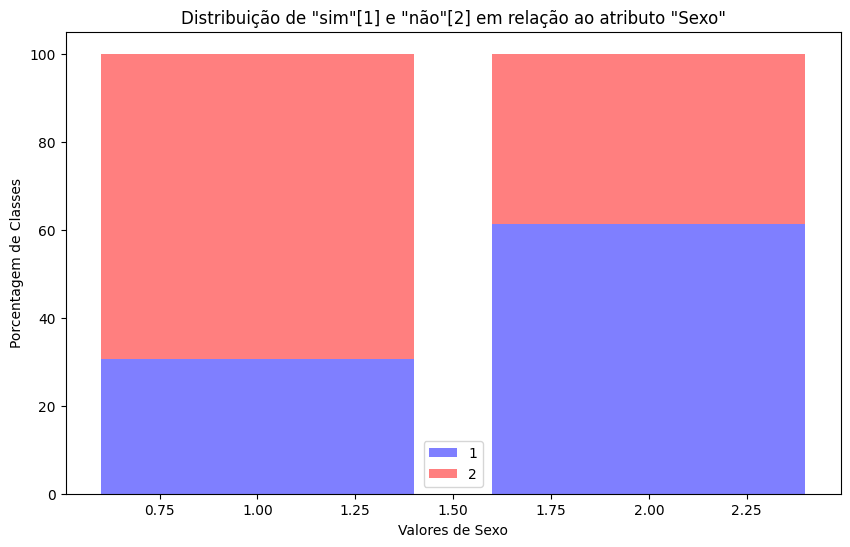

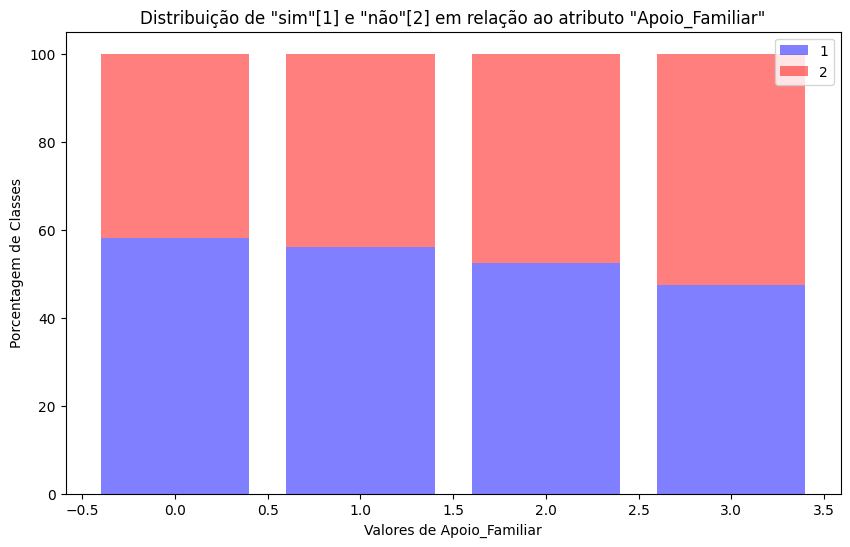

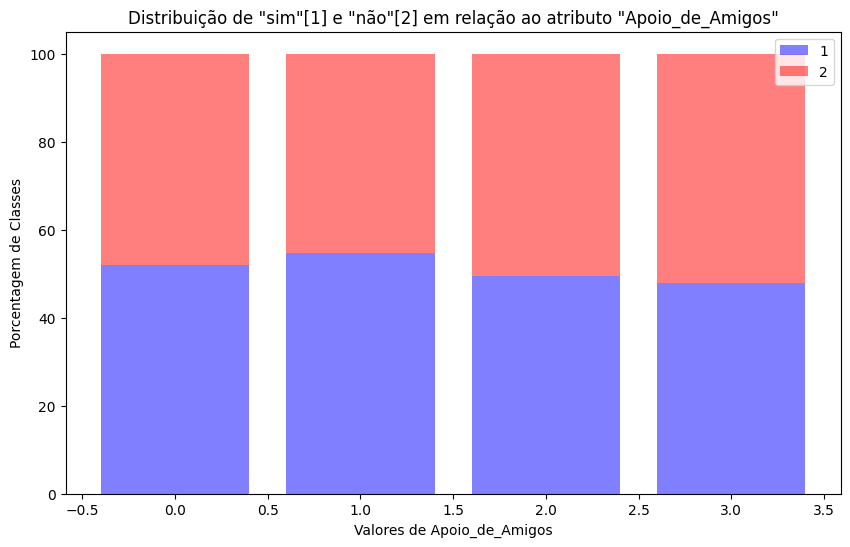

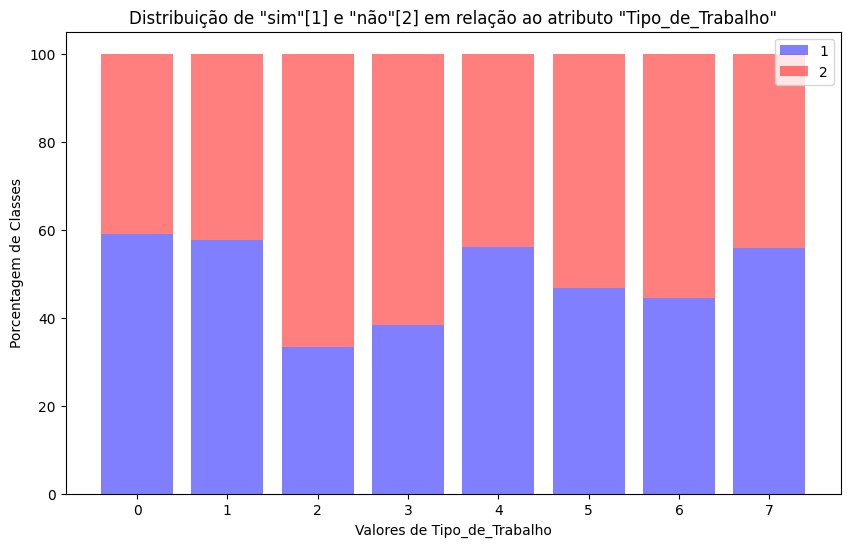

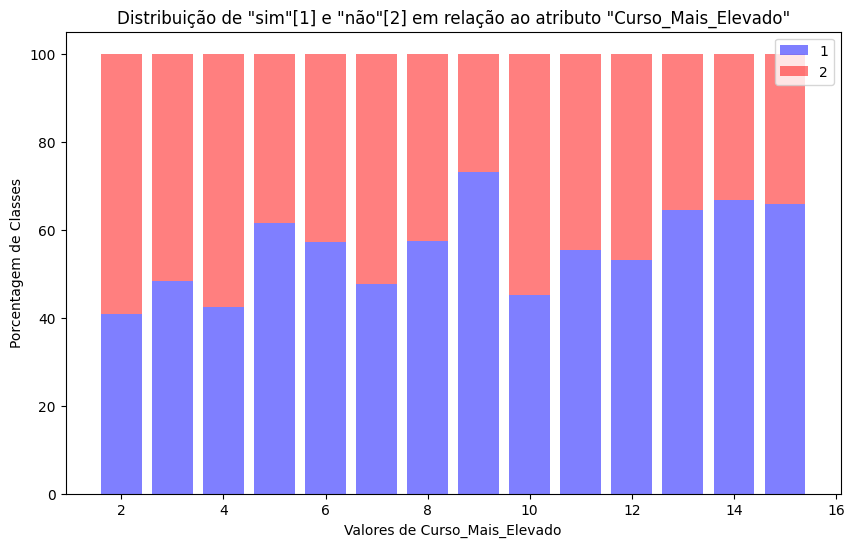

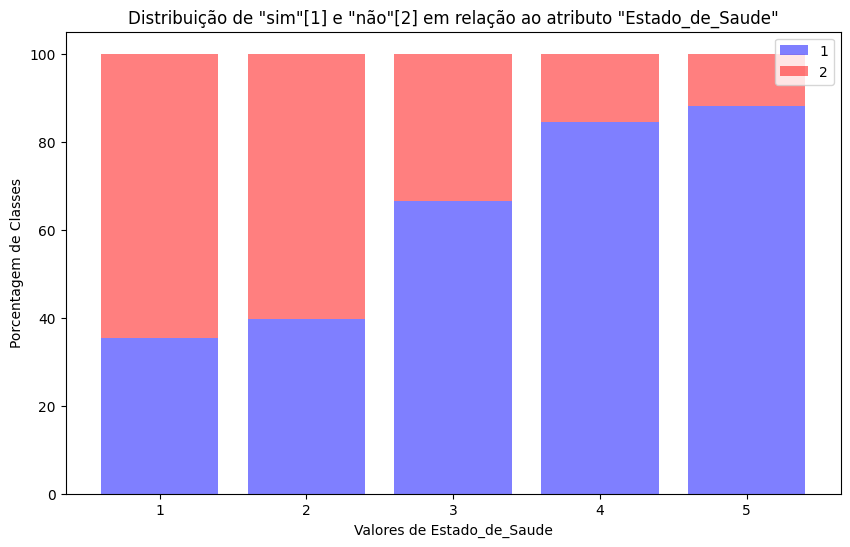

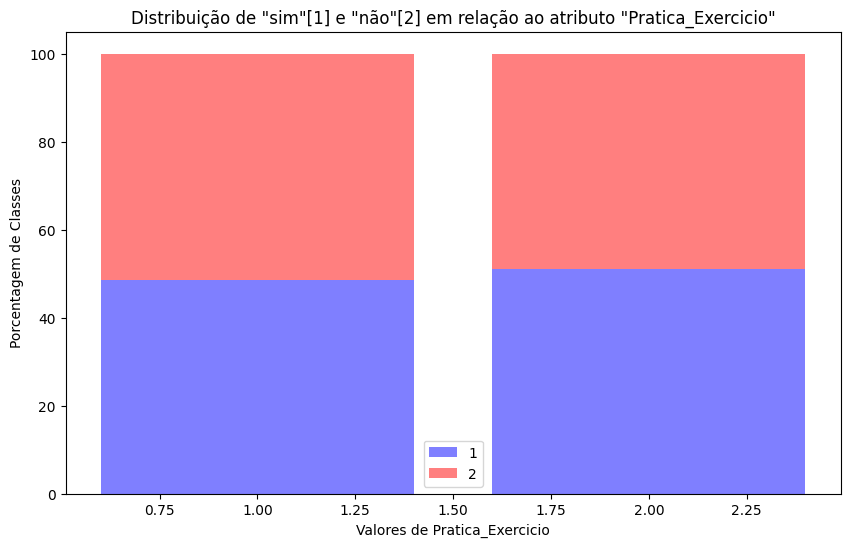

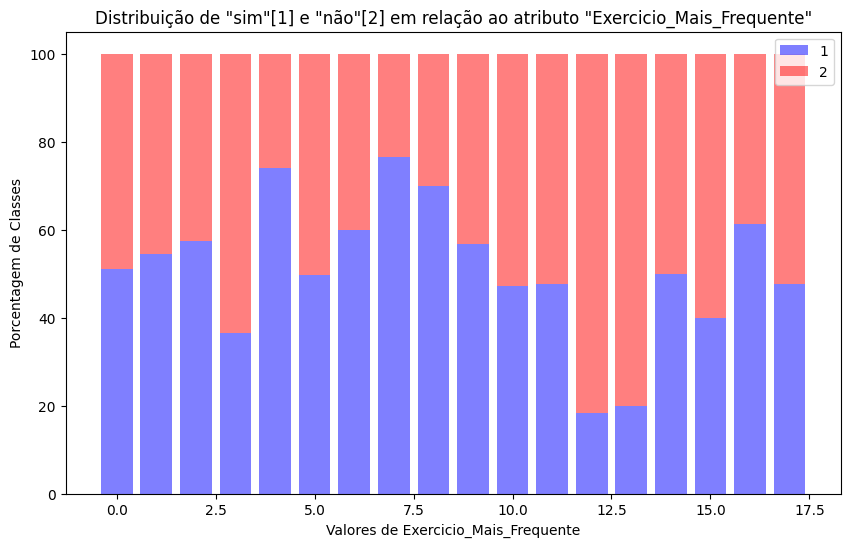

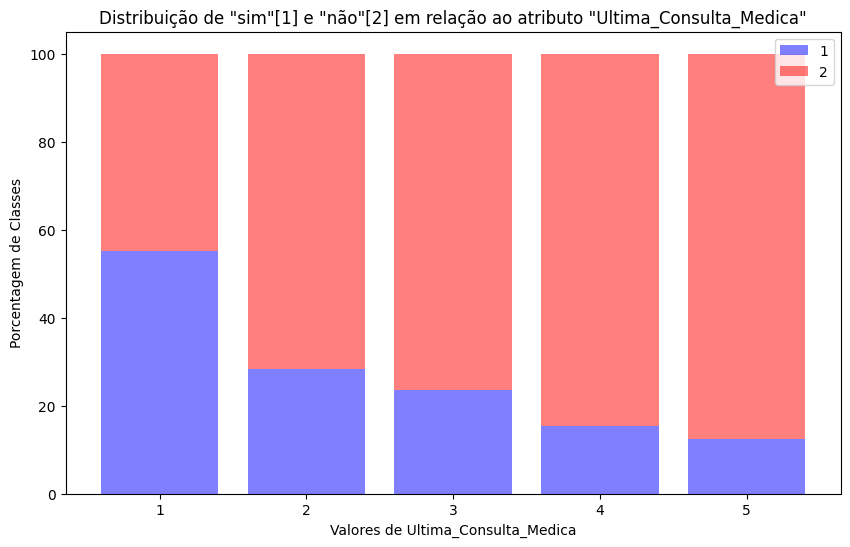

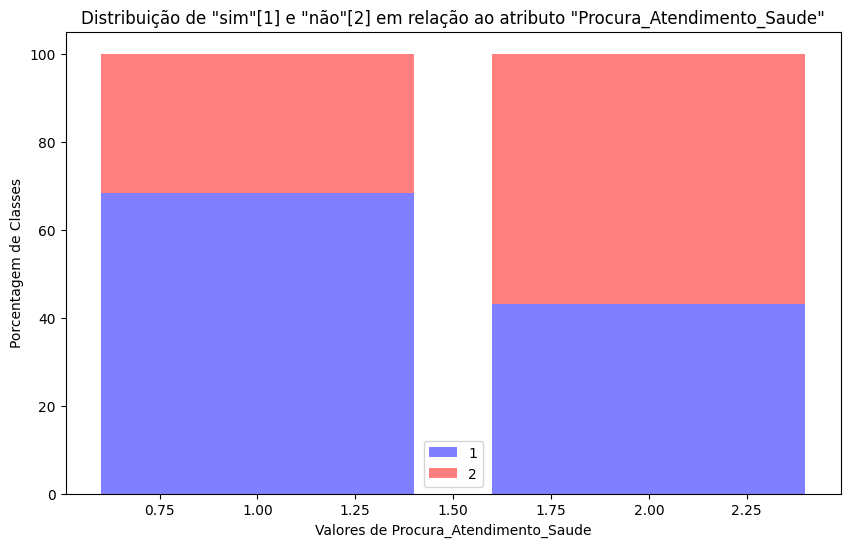

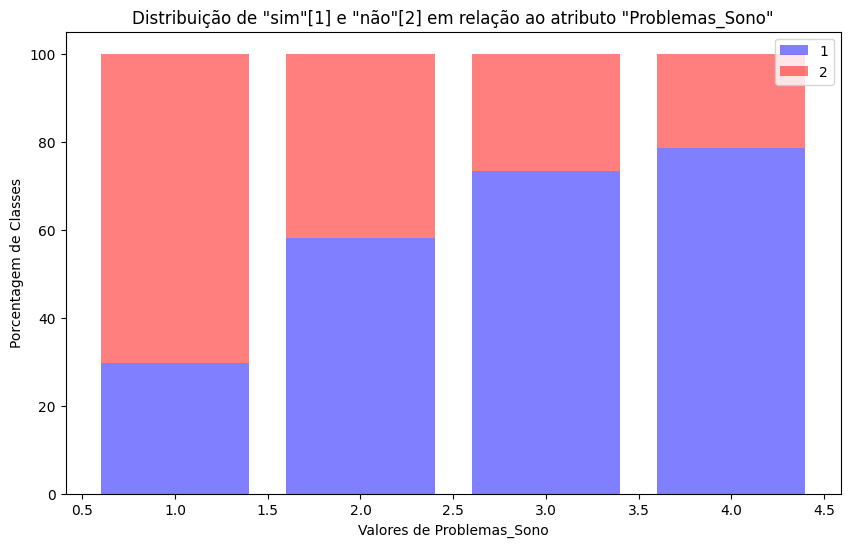

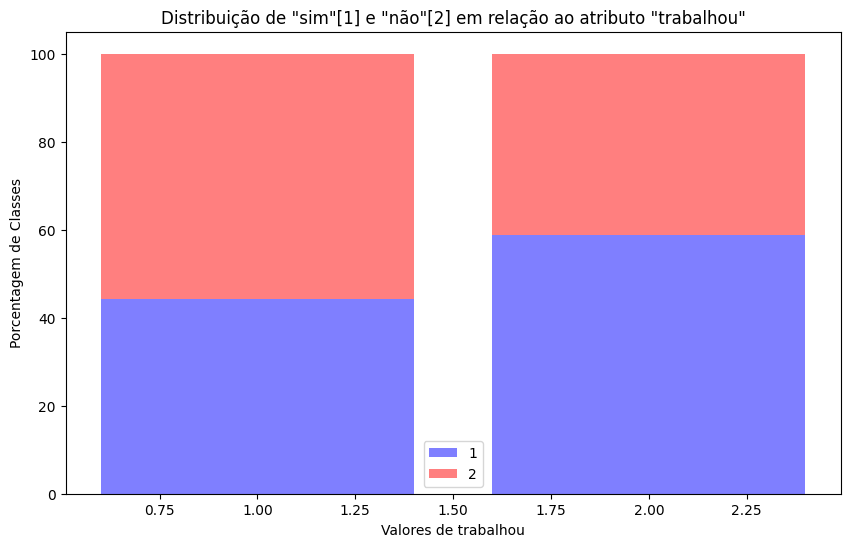

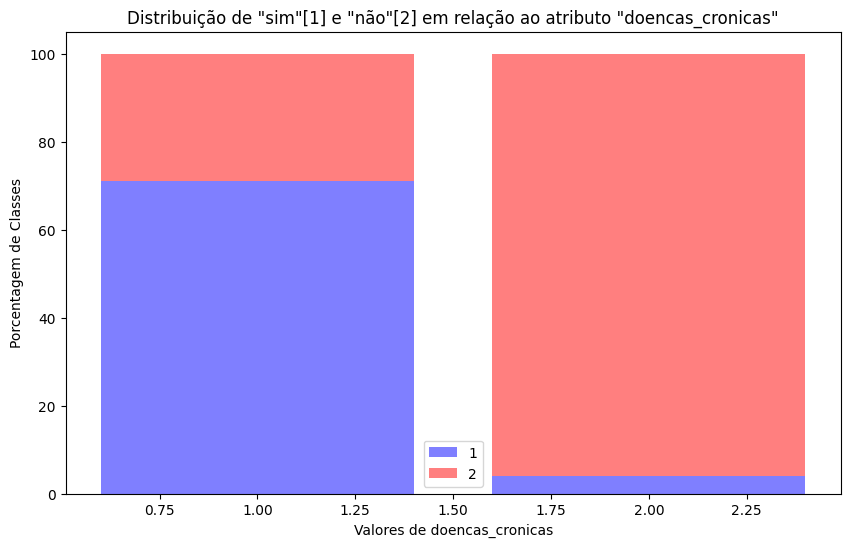

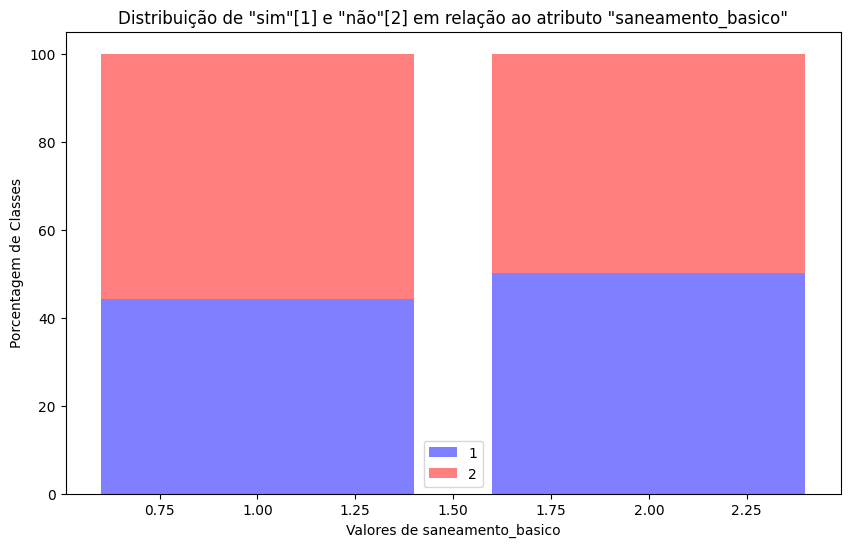

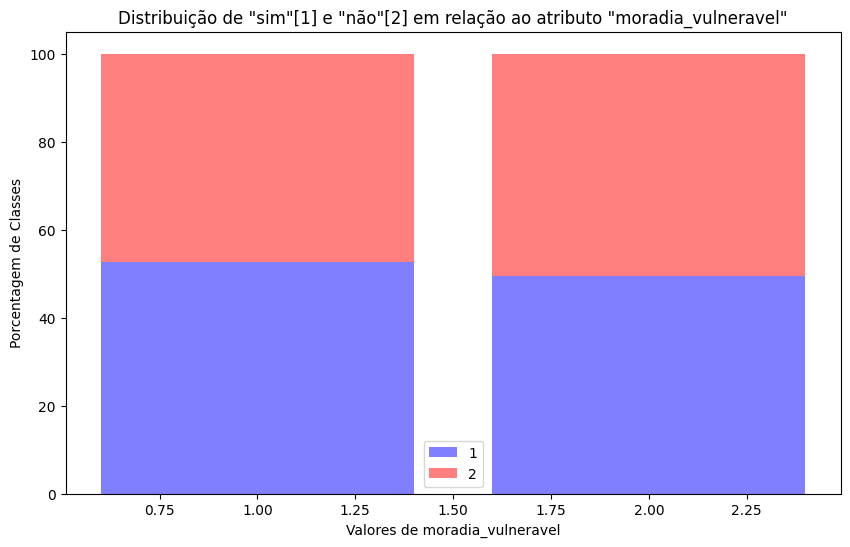

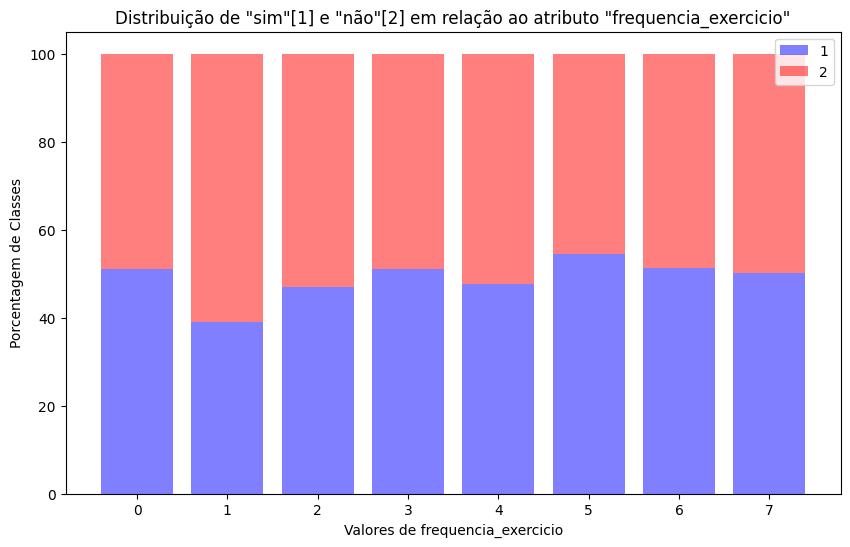

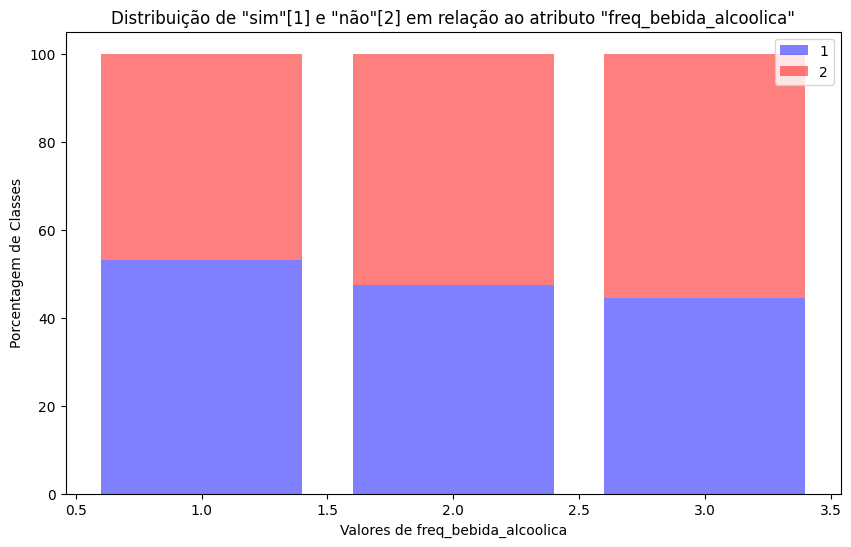

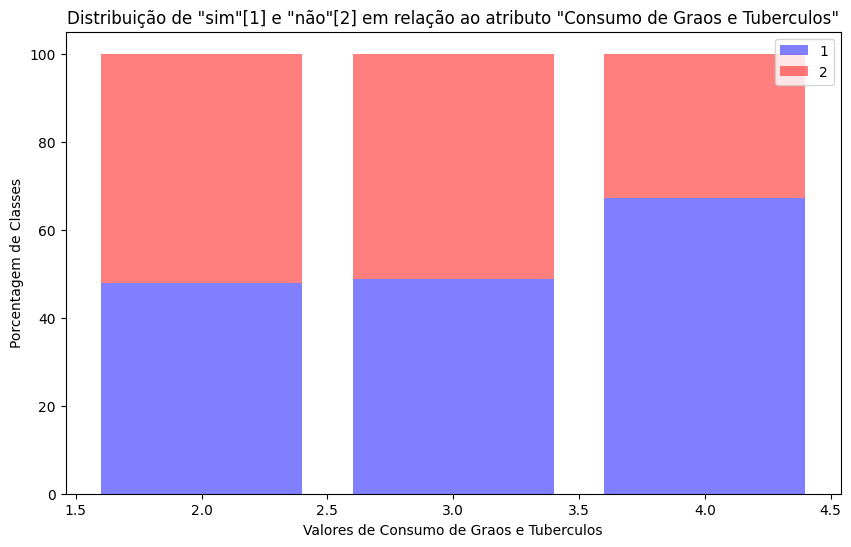

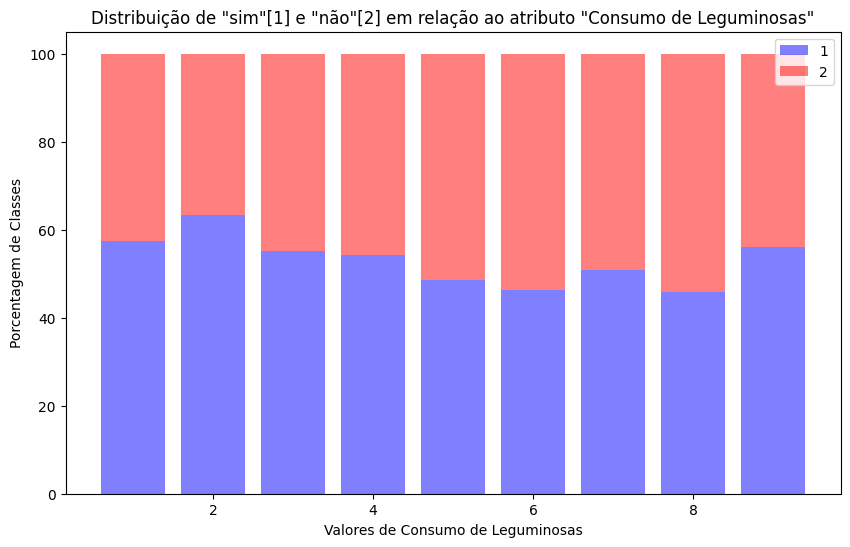

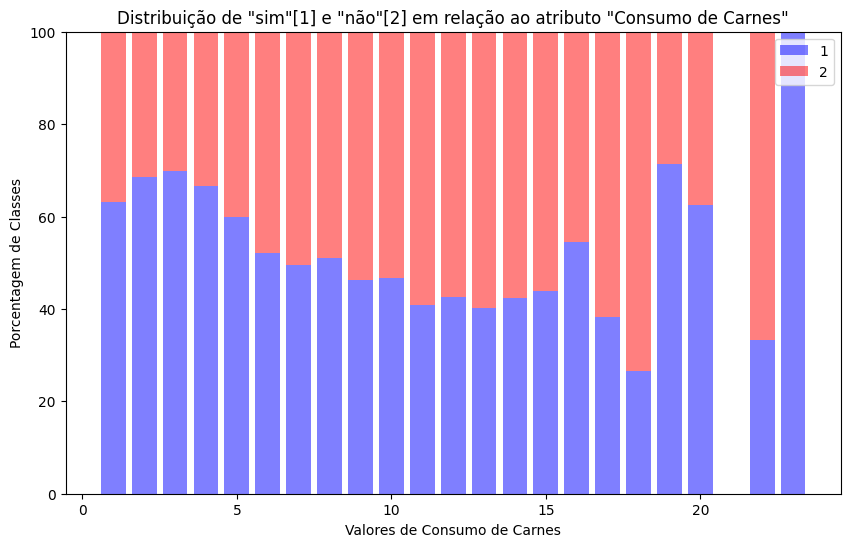

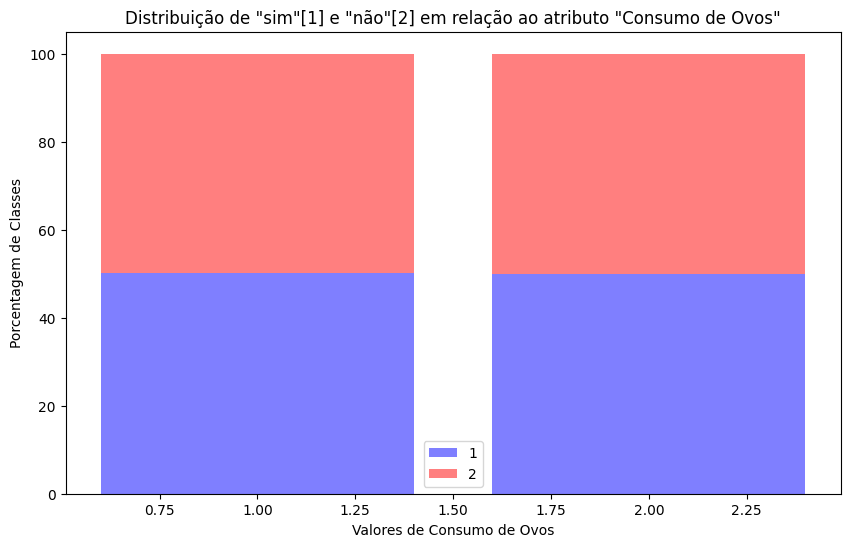

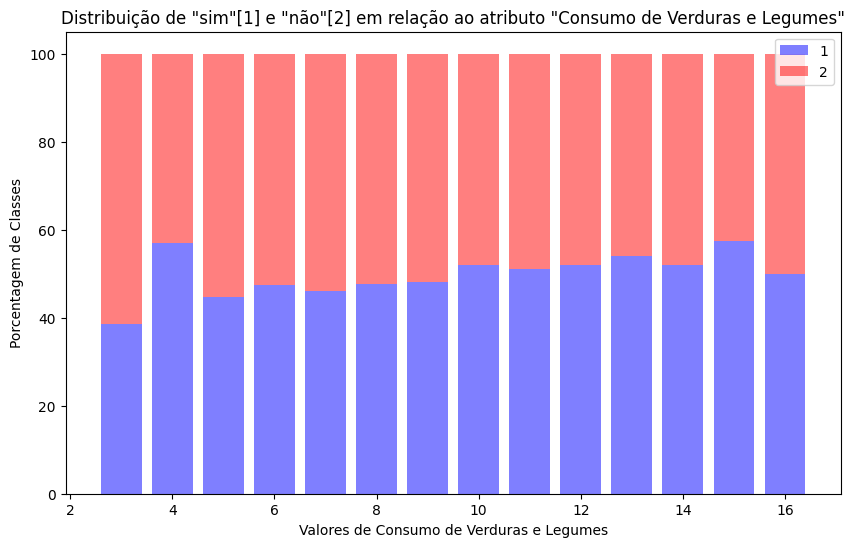

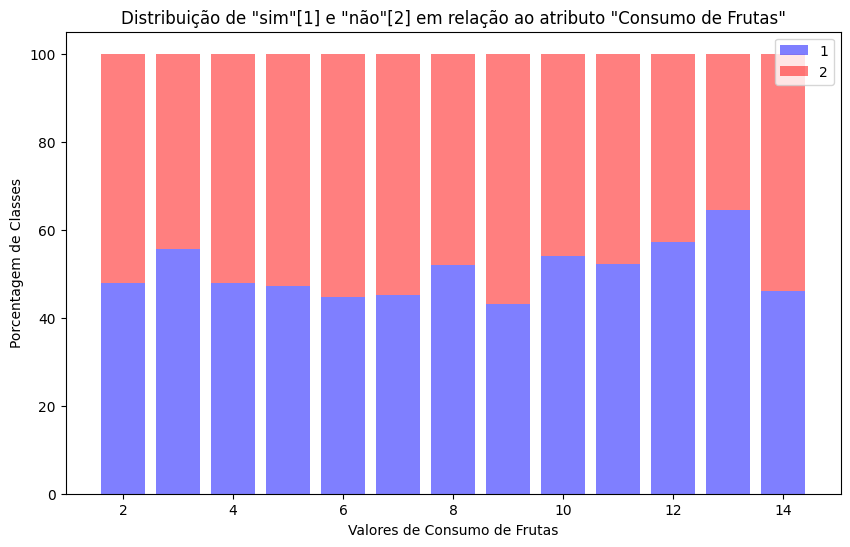

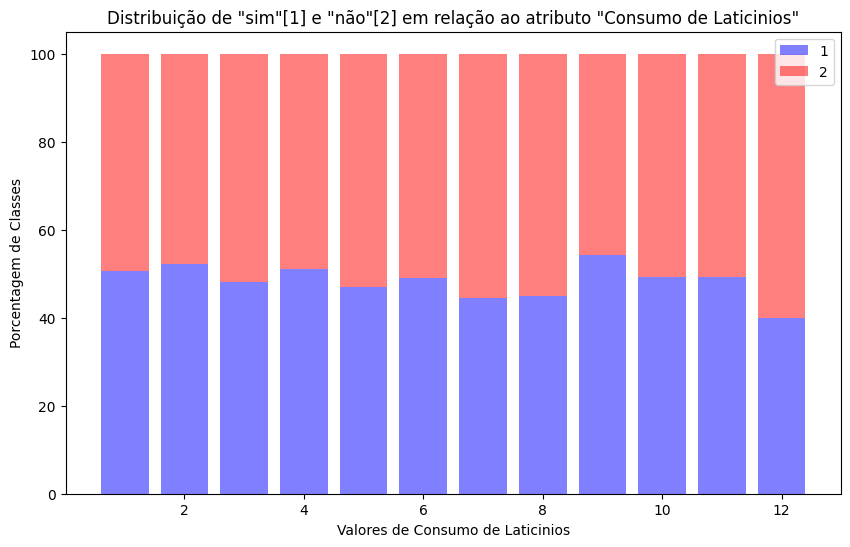

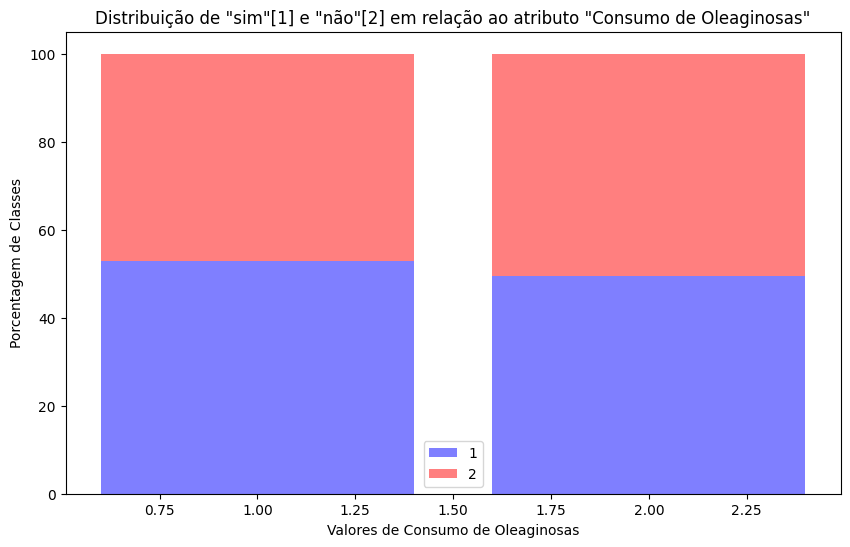

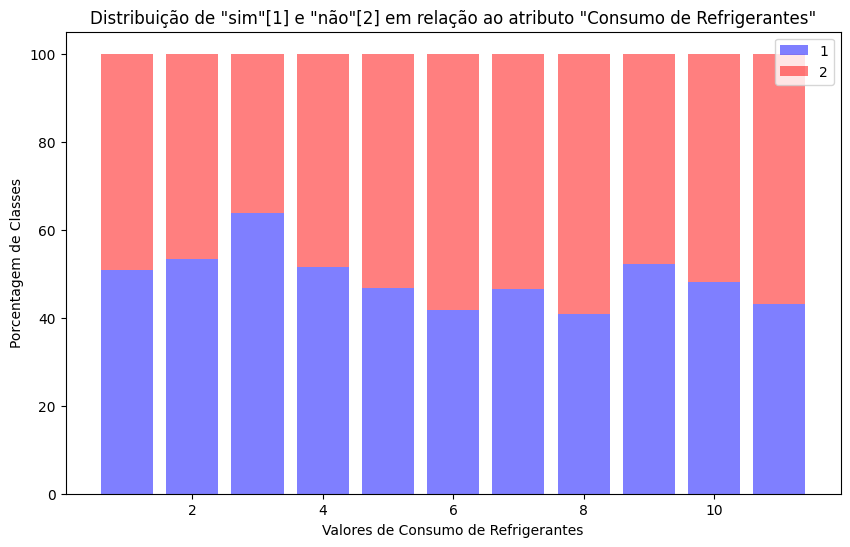

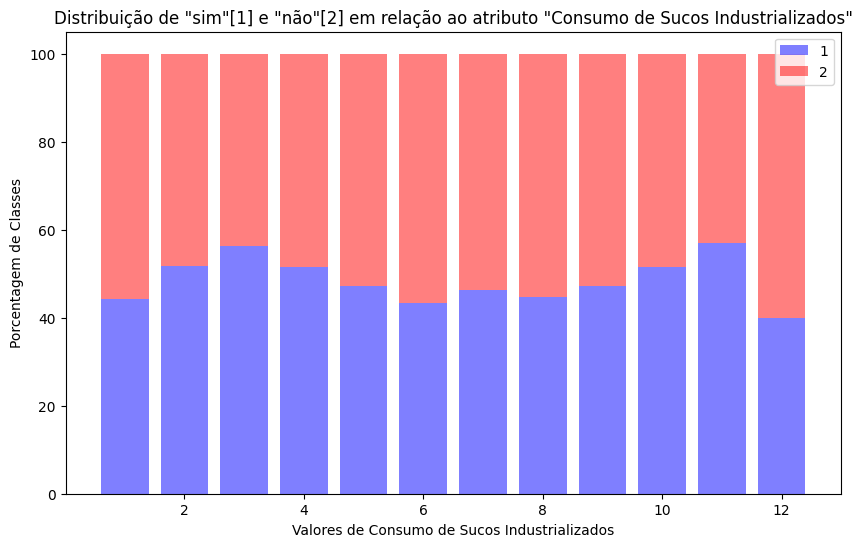

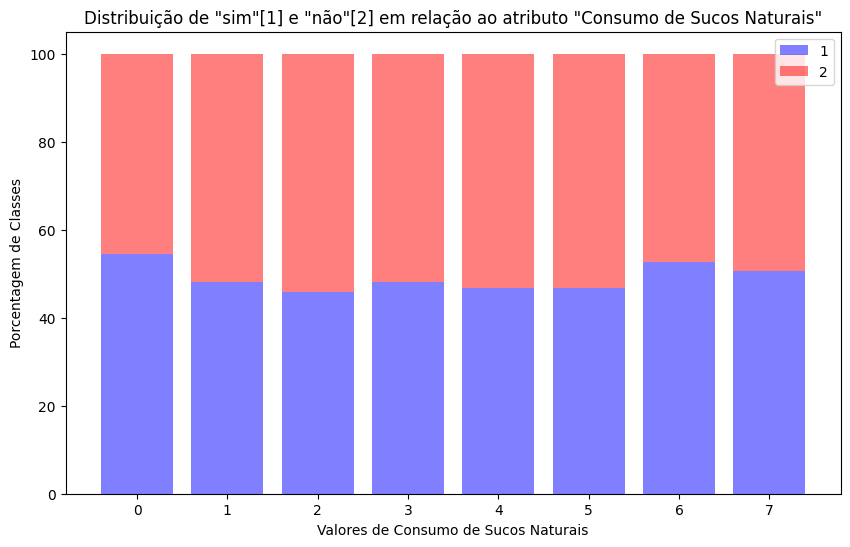

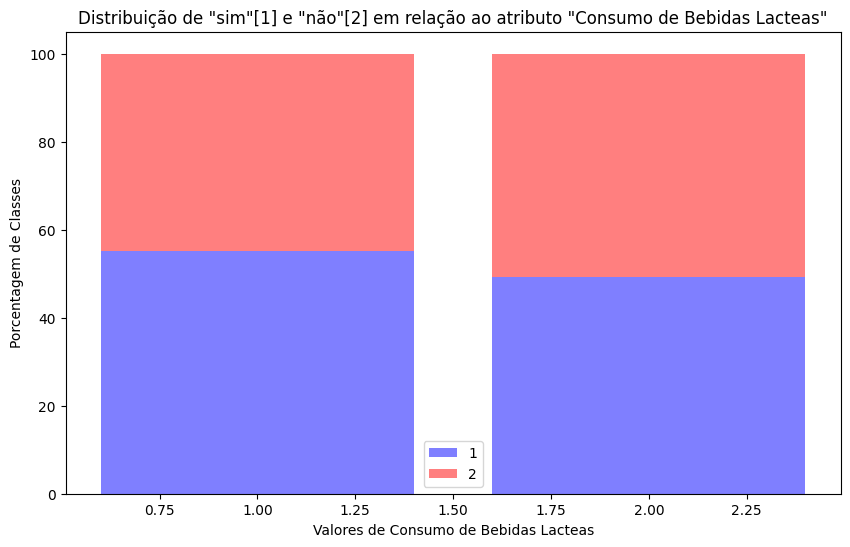

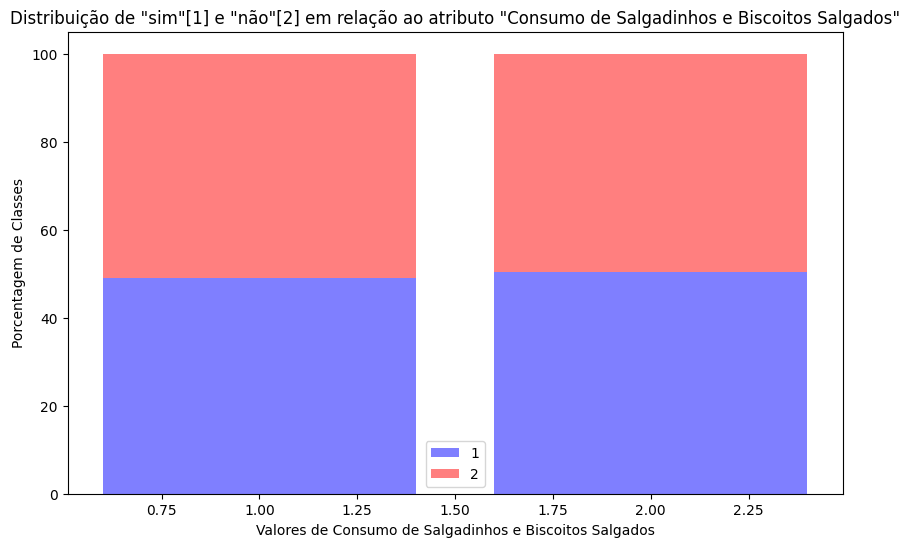

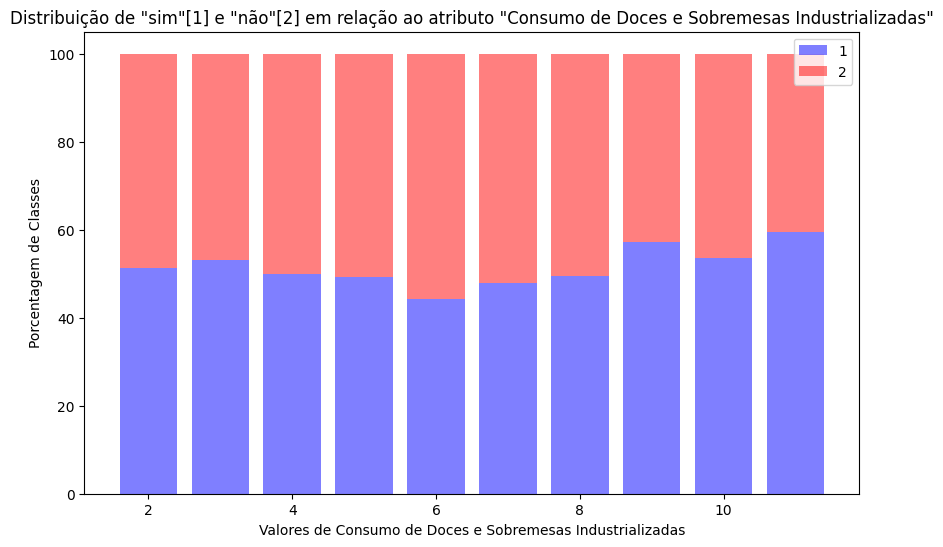

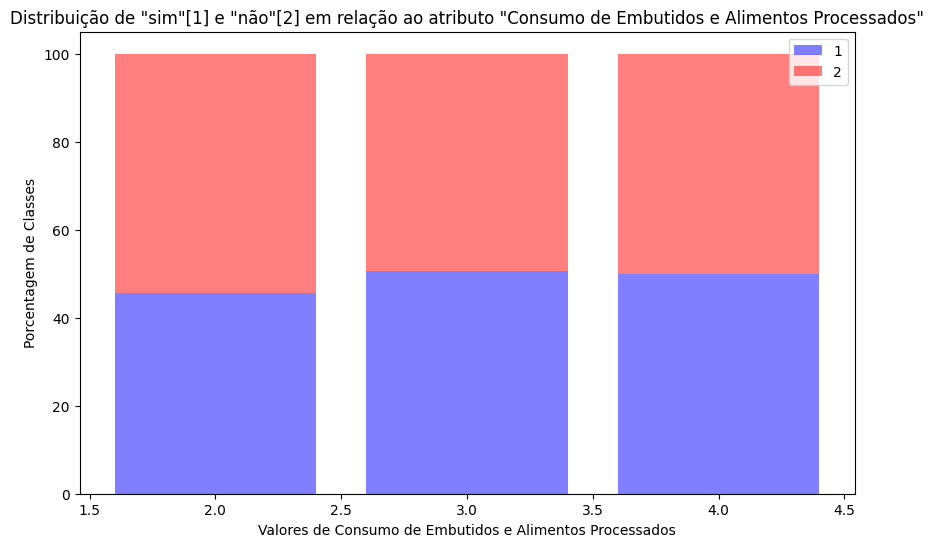

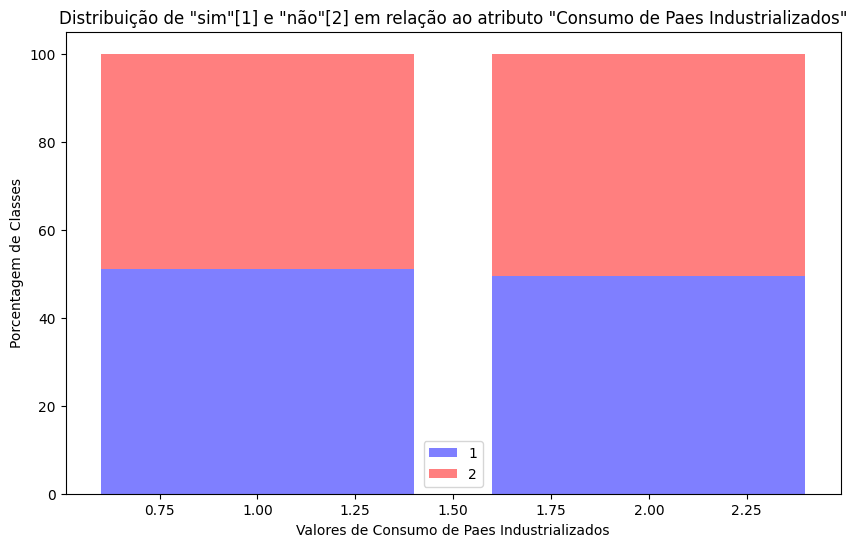

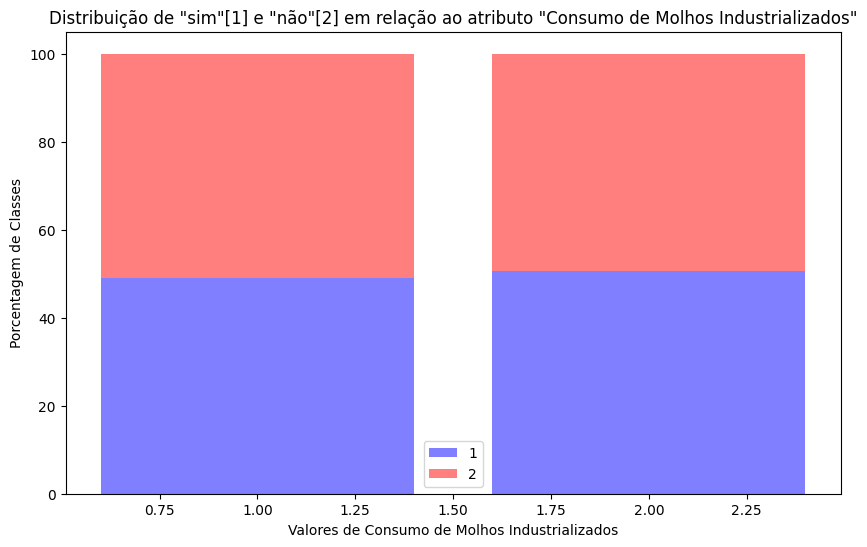

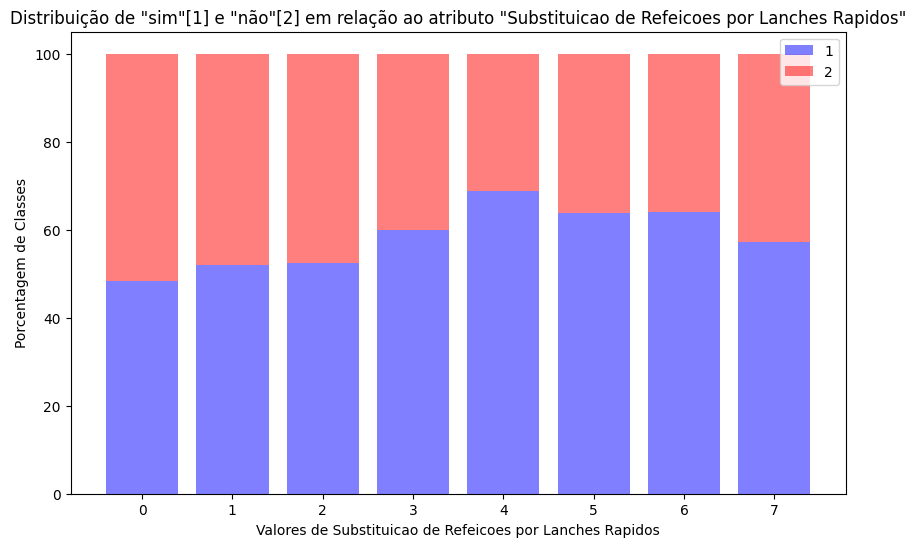

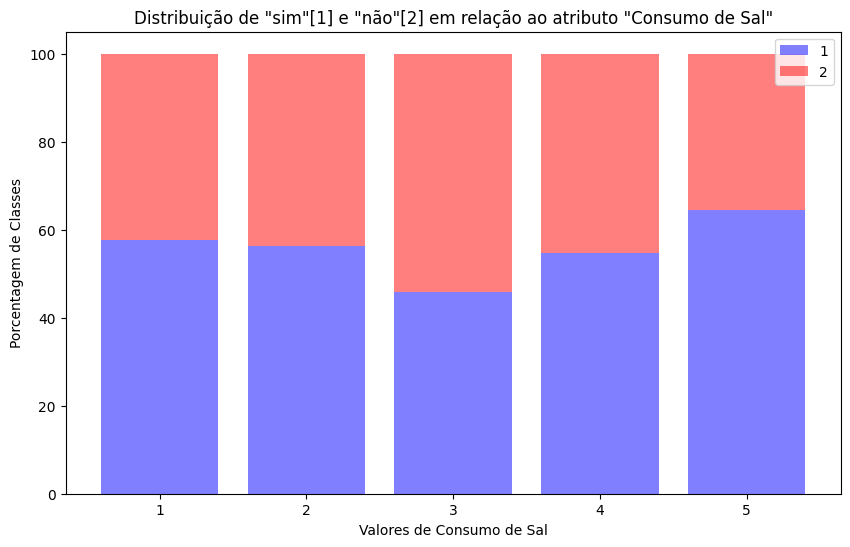

In [9]:
# Criando gráficos e exportando para um relatório

# Definindo a classe alvo
classe_alvo = 'Diagnostico_Depressao'

# Lista para armazenar os gráficos
graficos = []

# Iterando pelos atributos
for atributo in df.columns:
    if atributo != classe_alvo:
        # Agrupando os dados por atributo e classe alvo
        distribuicao = df.groupby([atributo, classe_alvo]).size().unstack()

        # Calculando o total de cada valor do atributo
        total_por_valor = distribuicao.sum(axis=1)
        
        porcentagem_sim = (distribuicao[1] / total_por_valor) * 100
        porcentagem_nao = (distribuicao[2] / total_por_valor) * 100

        # Definindo as labels para "sim" e "não"
        labels = {1: 'Sim', 2: 'Não'}

        plt.figure(figsize=(10, 6))
        plt.bar(porcentagem_sim.index, porcentagem_sim, color='b', alpha=0.5, label=1)
        plt.bar(porcentagem_nao.index, porcentagem_nao, color='r', alpha=0.5, bottom=porcentagem_sim, label=2)
        plt.xlabel(atributo)
        plt.ylabel('Porcentagem (%)')
        plt.title('Distribuição de "sim"[1] e "não"[2] em relação ao atributo "{}"'.format(atributo))
        plt.legend()

        plt.xlabel('Valores de {}'.format(atributo))
        plt.ylabel('Porcentagem de Classes')

        plt.show()
    

In [10]:
# Criando o ExcelWriter
writer = pd.ExcelWriter('relatorio_entropia.xlsx', engine='xlsxwriter')

# Exportando os resultados para uma planilha
resultados.to_excel(writer, sheet_name='Entropias', index=False)

# Criando uma nova planilha para os gráficos
workbook = writer.book
worksheet = workbook.add_worksheet('Gráficos')

# Iterando pelos gráficos e inserindo-os na planilha
row = 1
for grafico in graficos:
    worksheet.insert_image(f'A{row}', grafico['Nome do Arquivo'], {'x_scale': 0.8, 'y_scale': 0.8})
    row += 10  # Espaçamento entre os gráficos

# Salvando e fechando o ExcelWriter
writer._save()
